In [1]:
# to run if in Google colab, else the installation of modules in
# requirements.txt is sufficient

!git clone https://github.com/mattia01017/kernelized-linear-classification
import os
os.chdir("kernelized-linear-classification/src/")
%pip install -r ../requirements.txt

# Preprocessing

In [2]:
import csv
import matplotlib.pyplot as plt
import random
import json
from multiprocess.pool import Pool

import utils
import predictors
import kernels
import validation
from datatypes import BinaryClassifier, DataPoint, Label


X = []
Y = []

with open("your_dataset.csv") as f:
    csv_file = csv.reader(f)
    next(csv_file)  # skip header

    for line in csv_file:
        X.append((1.0,) + tuple(float(x) for x in line[:10]))
        Y.append(int(line[10]))

trainX, testX = X[:7000], X[7000:]
trainY, testY = Y[:7000], Y[7000:]

random.seed(1)
len(X)

10000

In [3]:
from collections import Counter
trainY_count = Counter(trainY)
testY_count = Counter(testY)
print(trainY_count[1], "positive training examples")
print(trainY_count[-1], "negative training examples")
print(testY_count[1], "positive testing examples")
print(testY_count[-1], "negative testing examples")

3479 positive training examples
3521 negative training examples
1513 positive testing examples
1487 negative testing examples


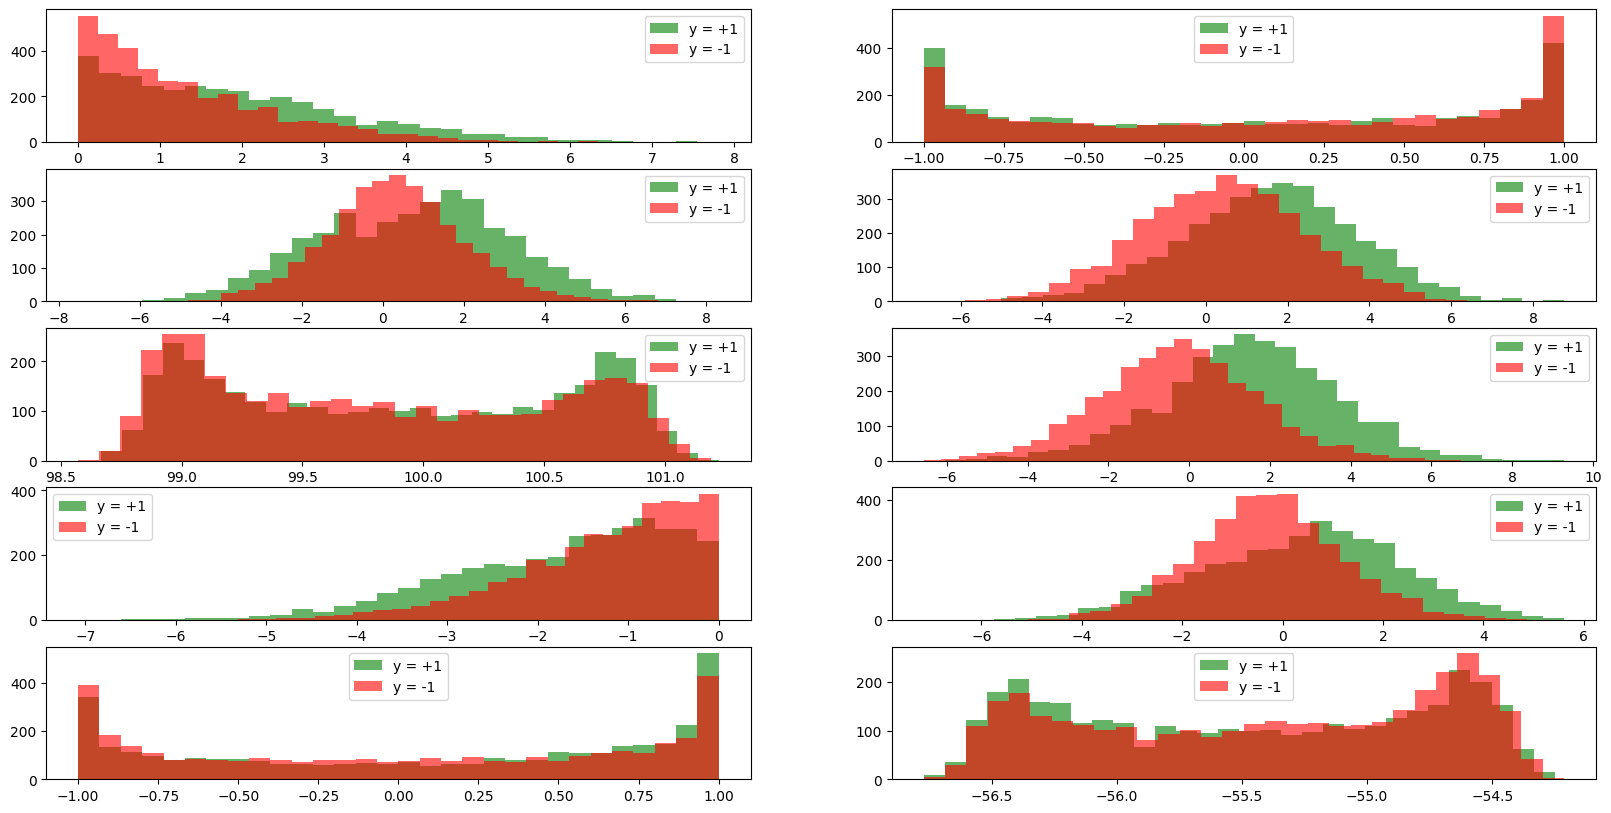

In [4]:
fig, axs = plt.subplots(5, 2)
fig.set_figwidth(20)
fig.set_figheight(10)

for i in range(1, 11):
    ax = axs[(i-1)%5][(i-1)//5]
    pos = [trainX[j][i] for j in range(len(trainX)) if trainY[j] == 1]
    neg = [trainX[j][i] for j in range(len(trainX)) if trainY[j] == -1]
    ax.hist(pos, alpha=0.6, color="green", bins=30)
    ax.hist(neg, alpha=0.6, color="red", bins=30)
    ax.legend(["y = +1", "y = -1"])
plt.show()

## Standardization

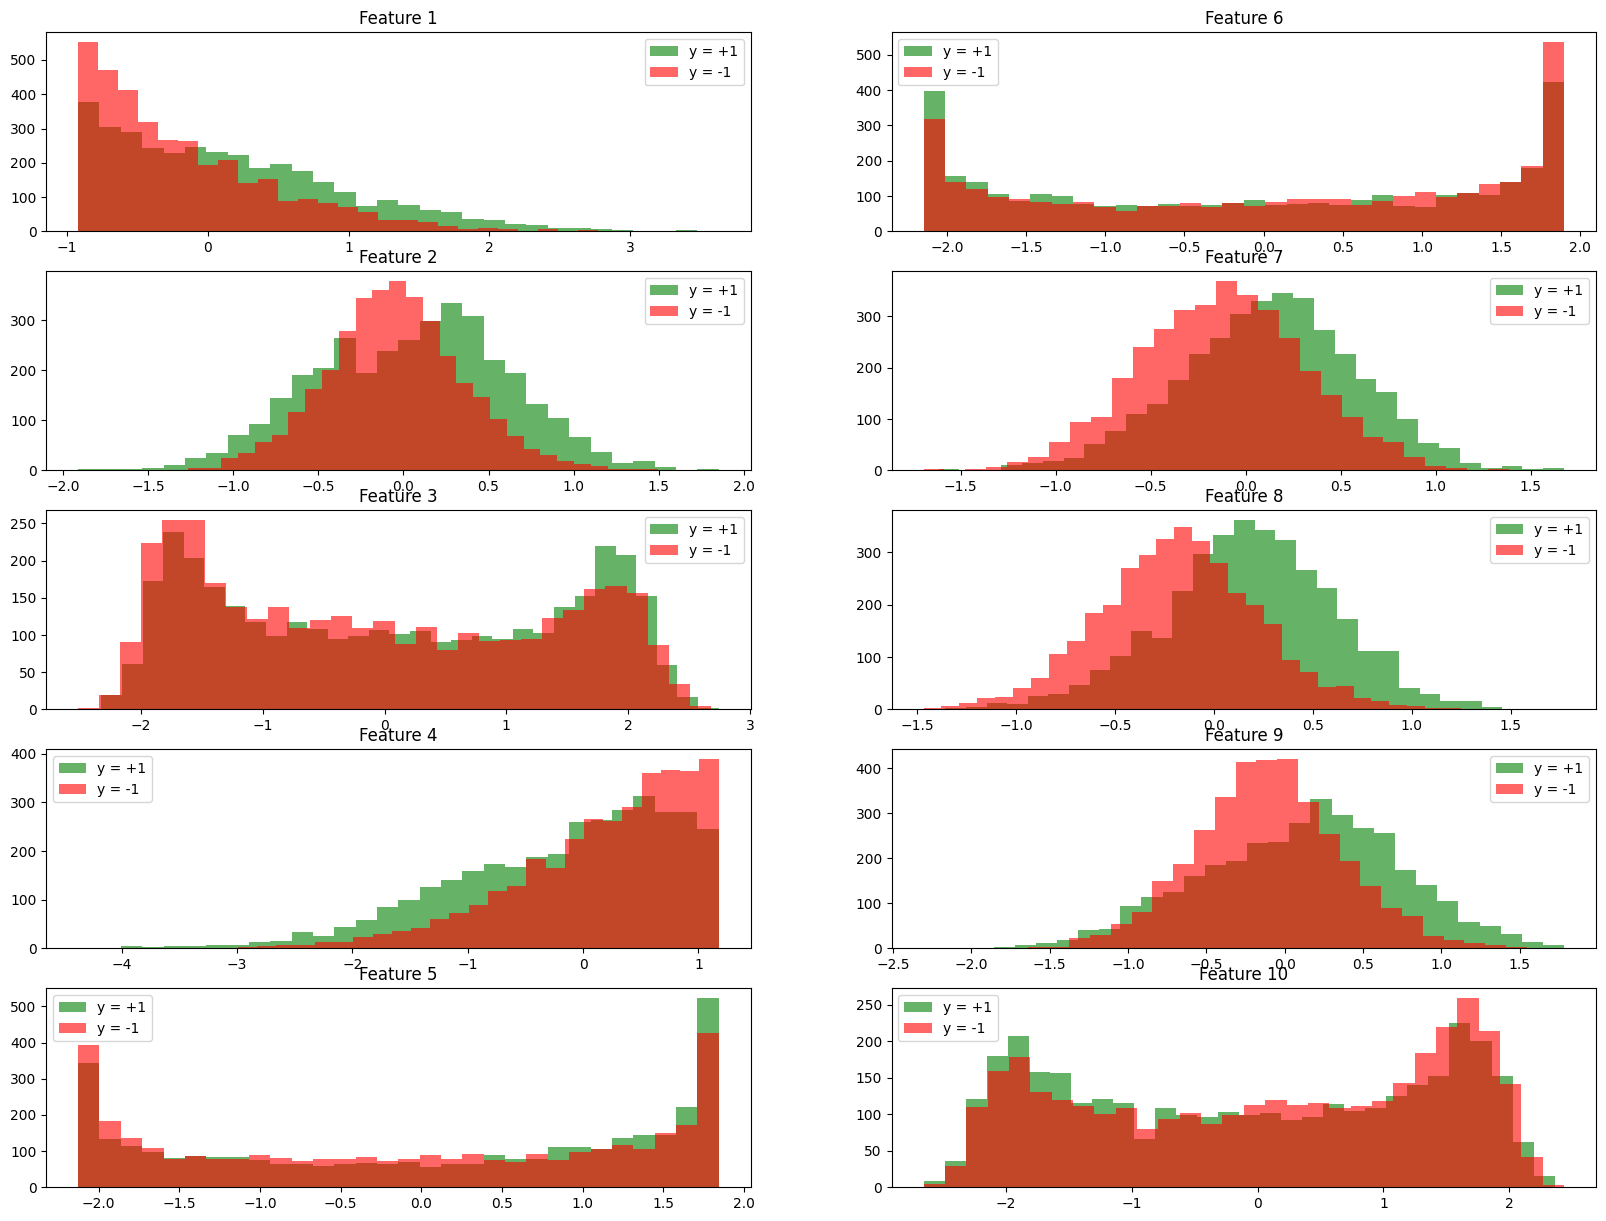

In [5]:
scaler = utils.ZScore()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)

fig, axs = plt.subplots(5, 2)
fig.set_figwidth(20)
fig.set_figheight(15)

for i in range(1, 11):
    ax = axs[(i-1)%5][(i-1)//5]
    pos = [trainX[j][i] for j in range(len(trainX)) if trainY[j] == 1]
    neg = [trainX[j][i] for j in range(len(trainX)) if trainY[j] == -1]
    ax.set_title(f"Feature {i}")
    ax.hist(pos, alpha=0.6, color="green", bins=30)
    ax.hist(neg, alpha=0.6, color="red", bins=30)
    ax.legend(["y = +1", "y = -1"])
plt.show()

In [6]:
def train_by_steps(
    model: BinaryClassifier,
    epoch_max: int,
    epoch_step: int,
    log: bool=True,
    trainX: list[DataPoint]=trainX,
    trainY: list[Label]=trainY,
    testX: list[DataPoint]=testX,
    testY: list[Label]=testY,
):
    warm = False

    train_err = []
    test_err = []
    epochs = range(epoch_step, epoch_max + 1, epoch_step)

    for e in epochs:
        model.fit(trainX, trainY, warm_start=warm)
        warm = True

        if log:
            print("Epoch:", e, end="\r")

        testY_pred = model.predict(testX)
        trainY_pred = model.predict(trainX)

        test_err.append(utils.zo_loss(testY, testY_pred))
        train_err.append(utils.zo_loss(trainY, trainY_pred))
    if log:
        print()
    return train_err, test_err, list(epochs)


# Perceptron

Epoch: 5000
Weights: [0.0, 3.881581249015114, 1.0422346589278932, -1.1471274014126112, -1.703519154641107, 2.859169425466596, 2.029297031511372, 3.844367357777289, 9.122874624397054, 1.2614753916431762, 1.7591593260785927]


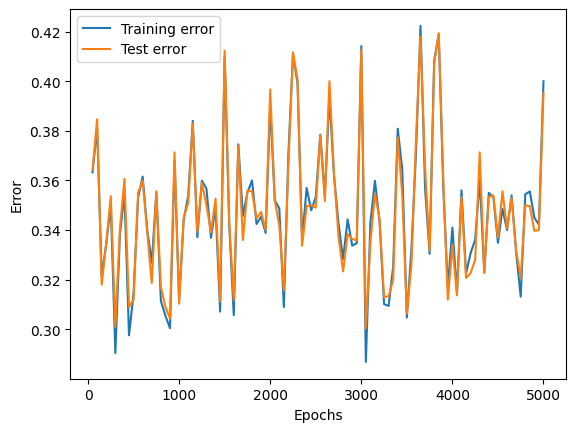

In [7]:
model = predictors.Perceptron(epochs_per_step=50)

train_err, test_err, epochs = train_by_steps(model, 5000, 50)

print("Weights:", model.w)
model.dump("../predictor_dumps/perceptron.json")

with open("../experiments/perceptron.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Using quadratic features

Epoch: 10000
Weight: [-34.0, 54.78297538128064, 5.101691713766547, -1.0684350845938397, -53.81738191888399, 43.386925743756805, -17.249737727150965, 95.04502284403452, 361.75710315084206, 117.79206954601848, 2.33815165963432, -8.143630426412939, 20.63173243072922, -11.682773729041182, -39.46042127788876, 1.6791355615063157, -17.08832519126419, 7.273294763943467, 308.18459281346344, -11.550596796156574, 1.4929611459034957, 25.54625243295379, -61.79220470113828, 33.96065755015493, -1.8864830533689996, -37.97624674992213, -7.263174819134605, 31.836005535380465, 1035.5418070633389, -30.25264064193529, -3.901159561894556, -7.944002456316278, -16.128648804067673, 6.264290137365184, 22.344986307844678, 10.723951149472473, 12.957819948694052, -8.373423727867225, 0.8045432453152208, 12.812397980340139, -6.895907509773359, 12.493845764967059, -231.07870892775543, 23.781400044467407, -2.7214579863614206, -8.724875301525824, -6.388456213496468, 4.360552662020851, 10.949956564433663, -3.51876943666

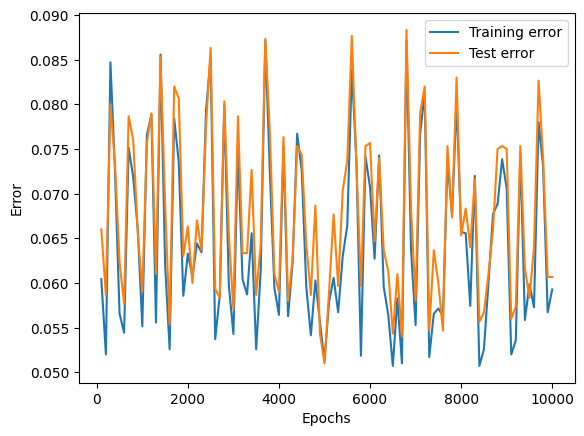

In [8]:
epoch_step = 100
model = predictors.Perceptron(epochs_per_step=epoch_step)

quad_trainX = [utils.quadratic_extraction(x[1:]) for x in trainX]  # type: ignore
quad_testX = [utils.quadratic_extraction(x[1:]) for x in testX]  # type: ignore
train_err, test_err, epochs = train_by_steps(model, 10001, epoch_step, trainX=quad_trainX, testX=quad_testX)

print("Weight:", model.w)
model.dump("../predictor_dumps/quad_perceptron.json")

with open("../experiments/quad_perceptron.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err}, f)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Polynomial Kernel

### Basic

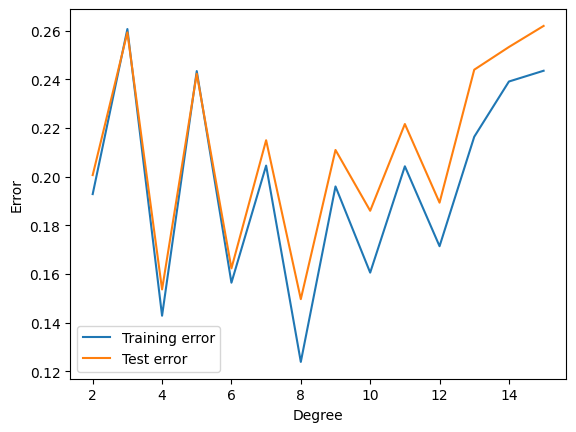

In [9]:
def create_and_train(deg):
    model = predictors.KernelPerceptron(kernels.polynomial(deg))
    model.fit(trainX, trainY)

    trainY_pred = model.predict(trainX)
    testY_pred = model.predict(testX)

    return utils.zo_loss(trainY, trainY_pred), utils.zo_loss(testY, testY_pred)


degrees = list(range(2, 16))

with Pool() as pool:
    result = pool.map(create_and_train, degrees)

train_errs = [x[0] for x in result]
test_errs = [x[1] for x in result]

with open("../experiments/perceptron_poly.json", "w") as f:
    json.dump({ "train_errs": train_errs, "test_errs": test_errs }, f)

plt.xlabel("Degree")
plt.ylabel("Error")
plt.plot(degrees, train_errs)
plt.plot(degrees, test_errs)
plt.legend(["Training error", "Test error"])
plt.show()

In [10]:
degrees = list(range(2, 10))

params = {
    "kernel": [kernels.polynomial(d) for d in degrees],
}

best_param, loss = validation.grid_search_cv(
    predictors.KernelPerceptron,
    X,
    Y,
    5,
    params,
    utils.ZScore
)

i = params["kernel"].index(best_param["kernel"])
del best_param["kernel"]
best_param["degree"] = degrees[i]

with open("../hyperparameters/poly_perceptron.json", "w") as f:
    json.dump(best_param, f)

best_param, loss

({'degree': 4}, 0.1427)

### Tunable number of epochs

Epoch: 20


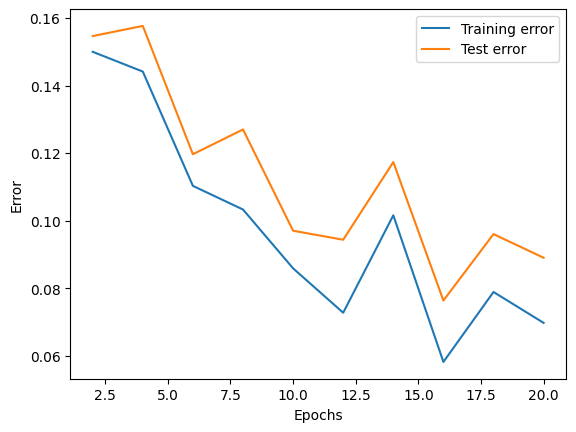

In [11]:
model = predictors.KernelPerceptron(kernels.polynomial(4), epochs_per_step=2)

train_err, test_err, epochs = train_by_steps(model, 20, 2)

with open("../experiments/perceptron_poly2.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": list(epochs)}, f)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Gaussian Kernel

### Basic

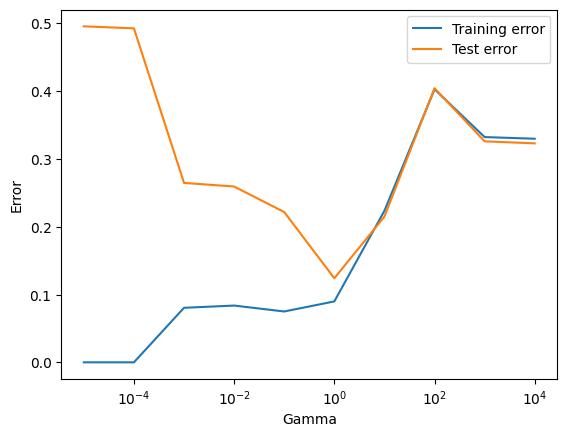

In [12]:
def create_and_train(gamma):
    model = predictors.KernelPerceptron(kernels.gaussian(gamma))
    model.fit(trainX, trainY)

    trainY_pred = model.predict(trainX)
    testY_pred = model.predict(testX)

    return utils.zo_loss(trainY, trainY_pred), utils.zo_loss(testY, testY_pred)

gammas = [pow(10, i) for i in range(-5, 5)]

with Pool() as pool:
    result = pool.map(create_and_train, gammas)

train_errs = [x[0] for x in result]
test_errs = [x[1] for x in result]

with open("../experiments/kgauss_perceptron.json", "w") as f:
    json.dump({"train_err": train_errs, "test_err": test_errs, "gamma": gammas}, f)

plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Error")
plt.plot(gammas, train_errs)
plt.plot(gammas, test_errs)
plt.legend(["Training error", "Test error"])
plt.show()

#### Grid search

In [13]:
gammas = [i * 0.5 for i in range(1, 11)]

params = {
    "kernel": [kernels.gaussian(g) for g in gammas]
}

best_param, loss = validation.grid_search_cv(
    predictors.KernelPerceptron,
    X,
    Y,
    5,
    params,
    utils.ZScore
)

i = params["kernel"].index(best_param["kernel"])

gammas[i], loss

(1.5, 0.12450000000000001)

### Tunable number of epochs

Epoch: 20


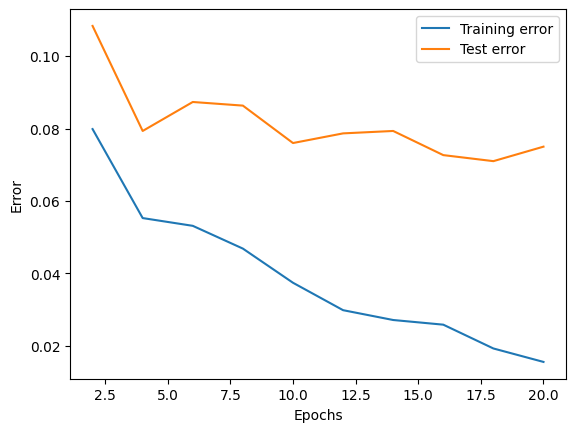

In [14]:
epoch_step = 2
model = predictors.KernelPerceptron(kernel=kernels.gaussian(1.5), epochs_per_step=epoch_step)

train_errs, test_errs, epochs = train_by_steps(model, 20, epoch_step)

with open("../experiments/kgauss_perceptron2.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(epochs, train_errs)
plt.plot(epochs, test_errs)
plt.legend(["Training error", "Test error"])
plt.show()

# SVM

## Using hinge loss

### Parameter tuning via Grid search

In [9]:
params = {
    "epochs_per_step": [1000, 5000, 10000, 15000],
    "learning_rate": [pow(10, i) for i in range(-3, 3)],
    "regularization": [pow(10, i) for i in range(-3, 3)],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    utils.ZScore,
)

del best_param["random"]
with open("../hyperparameters/svm.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)

best_param, loss

({'epochs_per_step': 10000, 'learning_rate': 1, 'regularization': 0.001},
 0.27769999999999995)

In [12]:
params = {
    "epochs_per_step": [15000, 18000, 20000],
    "learning_rate": [0.5 * i for i in range(1, 11)],
    "regularization": [0.0005 * i for i in range(1, 11)],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    utils.ZScore,
)

del best_param["random"]
with open("../hyperparameters/svm2.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)

best_param, loss

({'epochs_per_step': 20000, 'learning_rate': 0.5, 'regularization': 0.003},
 0.2752)

Epoch: 10000


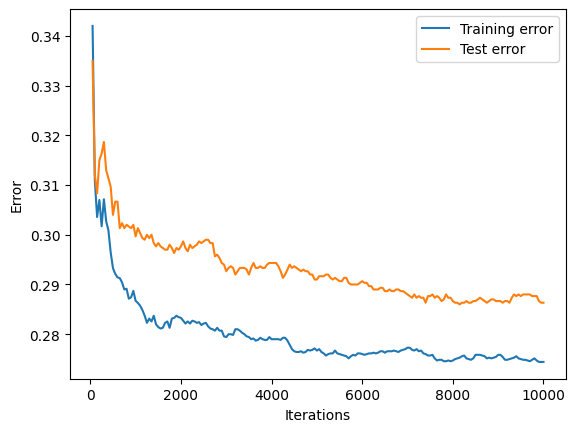

In [13]:
with open("../hyperparameters/svm2.json") as f:
    best_param = json.load(f)["params"]

del best_param["epochs_per_step"]

model = predictors.SVM(**best_param, epochs_per_step=50, random=random.Random(1))
train_err, test_err, epochs = train_by_steps(model, 10000, 50)
model.dump("../predictor_dumps/svm.json")

with open("../experiments/svm.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Iterations")
plt.ylabel("Error")

plt.show()

#### Quadratic features

In [18]:
params = {
    "epochs_per_step": [1000, 5000, 10000, 15000],
    "learning_rate": [pow(10, i) for i in range(-3, 3)],
    "regularization": [pow(10, i) for i in range(-3, 3)],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    Scaler=utils.ZScore,
    extraction=utils.quadratic_extraction,
)

del best_param["random"]
with open("../hyperparameters/quad_svm.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)

best_param, loss

({'epochs_per_step': 15000, 'learning_rate': 1, 'regularization': 0.001},
 0.0958)

In [19]:
params = {
    "epochs_per_step": [15000, 18000, 20000],
    "learning_rate": [0.3 * i for i in range(1, 11)],
    "regularization": [0.0008 * i for i in range(1, 11)],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    Scaler=utils.ZScore,
    extraction=utils.quadratic_extraction,
)

del best_param["random"]
with open("../hyperparameters/quad_svm2.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)

best_param, loss

({'epochs_per_step': 20000,
  'learning_rate': 2.6999999999999997,
  'regularization': 0.0008},
 0.0811)

Epoch: 150000


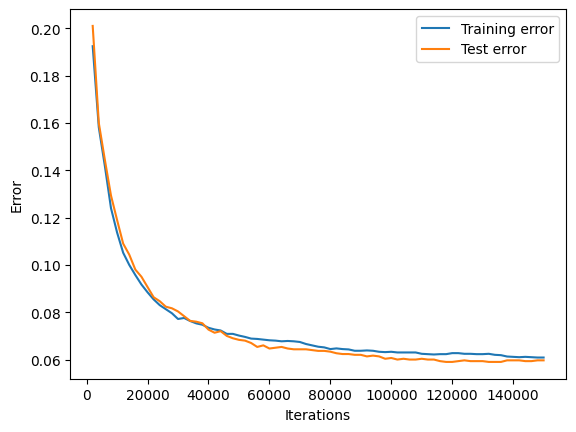

In [20]:
with open("../hyperparameters/quad_svm2.json") as f:
    best_param = json.load(f)["params"]

del best_param["epochs_per_step"]

model = predictors.SVM(**best_param, epochs_per_step=2000, random=random.Random(1))
train_err, test_err, epochs = train_by_steps(
    model,
    150000,
    2000,
    trainX=[utils.quadratic_extraction(x) for x in trainX],
    testX=[utils.quadratic_extraction(x) for x in testX],
)

model.dump("../predictor_dumps/quad_svm.json")

with open("../experiments/quad_svm.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)


plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Iterations")
plt.ylabel("Error")

plt.show()

## Using logistic loss

### Parameter tuning via Grid search

In [21]:
params = {
    "epochs_per_step": [1000, 5000, 10000, 15000],
    "learning_rate": [pow(10, i) for i in range(-3, 3)],
    "regularization": [pow(10, i) for i in range(-3, 3)],
    "loss_func": ["logistic"],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    utils.ZScore,
)

del best_param["random"]
with open("../hyperparameters/svm_log.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)

best_param, loss

({'epochs_per_step': 15000,
  'learning_rate': 100,
  'regularization': 0.001,
  'loss_func': 'logistic'},
 0.2799)

In [22]:
params = {
    "epochs_per_step": [15000, 18000, 20000],
    "learning_rate": [20*i for i in range(1, 11)],
    "regularization": [0.0005*i for i in range(1, 11)],
    "loss_func": ["logistic"],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    utils.ZScore,
)

del best_param["random"]
with open("../hyperparameters/svm2_log.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)

best_param, loss

({'epochs_per_step': 18000,
  'learning_rate': 100,
  'regularization': 0.0005,
  'loss_func': 'logistic'},
 0.2786)

Epoch: 20000


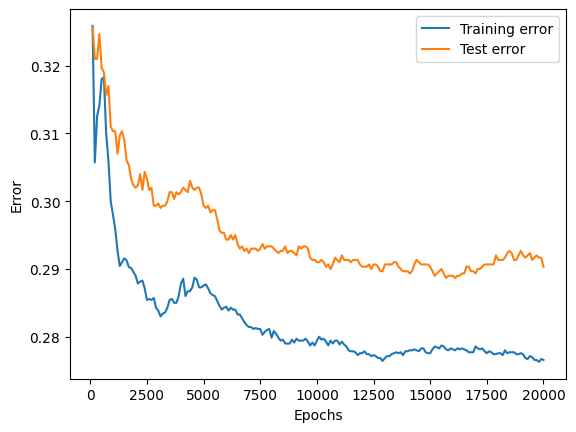

In [23]:
with open("../hyperparameters/svm2_log.json") as f:
    best_param = json.load(f)["params"]

del best_param["epochs_per_step"]


model = predictors.SVM(**best_param, epochs_per_step=50, random=random.Random(1))
train_err, test_err, epochs = train_by_steps(model, 20000, 100)
model.dump("../predictor_dumps/svm_log.json")

with open("../experiments/svm_log.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

#### Quadratic features

In [24]:
params = {
    "epochs_per_step": [1000, 5000, 10000, 15000],
    "learning_rate": [pow(10, i) for i in range(-3, 3)],
    "regularization": [pow(10, i) for i in range(-3, 3)],
    "loss_func": ["logistic"],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    Scaler=utils.ZScore,
    extraction=utils.quadratic_extraction,
)

del best_param["random"]
with open("../hyperparameters/quad_svm_log.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)


best_param, loss

({'epochs_per_step': 15000,
  'learning_rate': 1,
  'regularization': 0.001,
  'loss_func': 'logistic'},
 0.09760000000000002)

In [25]:
params = {
    "epochs_per_step": [15000, 18000, 20000],
    "learning_rate": [0.3*i for i in range(1, 11)],
    "regularization": [0.0005*i for i in range(1, 11)],
    "loss_func": ["logistic"],
    "random": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.SVM,
    X,
    Y,
    5,
    params,
    utils.ZScore,
    extraction=utils.quadratic_extraction,
)

del best_param["random"]
with open("../hyperparameters/quad_svm2_log.json", "w") as f:
    json.dump({"params": best_param, "loss": loss}, f)

best_param, loss

({'epochs_per_step': 20000,
  'learning_rate': 2.6999999999999997,
  'regularization': 0.0005,
  'loss_func': 'logistic'},
 0.076)

Epoch: 200000


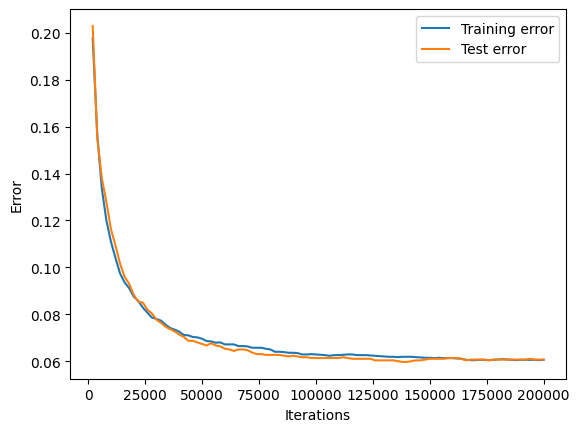

In [26]:
with open("../hyperparameters/quad_svm2_log.json") as f:
    best_param = json.load(f)["params"]

del best_param["epochs_per_step"]

model = predictors.SVM(**best_param, epochs_per_step=2000, random=random.Random(1))
train_err, test_err, epochs = train_by_steps(
    model,
    200000,
    2000,
    trainX=[utils.quadratic_extraction(x) for x in trainX],
    testX=[utils.quadratic_extraction(x) for x in testX],
)

model.dump("../predictor_dumps/quad_svm_log.json")

with open("../experiments/quad_svm_log.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Iterations")
plt.ylabel("Error")

plt.show()

## Polynomial kernel

In [27]:
degrees = list(range(2, 10))

params = {
    "epochs_per_step": [2000],
    "regularization": [pow(10, i) for i in range(-3, 3)],
    "kernel": [kernels.polynomial(d) for d in degrees],
    "rand": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.KernelSVM,
    X,
    Y,
    5,
    params,
    utils.ZScore
)

i = params["kernel"].index(best_param["kernel"])
del best_param["kernel"]
del best_param["rand"]
best_param["degree"] = degrees[i]

with open("../hyperparameters/poly_svm.json", "w") as f:
    json.dump(best_param, f)

best_param, loss

({'epochs_per_step': 2000, 'regularization': 0.001, 'degree': 4},
 0.20129999999999998)

In [28]:
degrees = [3, 4, 5]

params = {
    "epochs_per_step": [2000],
    "regularization": [0.0005*i for i in range(1, 6)],
    "kernel": [kernels.polynomial(d) for d in degrees],
    "rand": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.KernelSVM,
    X,
    Y,
    5,
    params,
    utils.ZScore
)

i = params["kernel"].index(best_param["kernel"])
del best_param["kernel"]
del best_param["rand"]
best_param["degree"] = degrees[i]

with open("../hyperparameters/poly_svm2.json", "w") as f:
    json.dump(best_param, f)

best_param, loss

({'epochs_per_step': 2000, 'regularization': 0.0005, 'degree': 4},
 0.20129999999999998)

Epoch: 60000


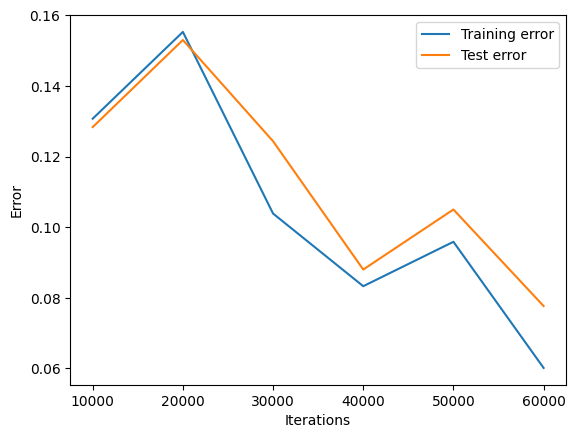

In [29]:
with open("../hyperparameters/poly_svm2.json") as f:
    best_param = json.load(f)

model = predictors.KernelSVM(
    epochs_per_step=10000,
    regularization=best_param["regularization"],
    kernel=kernels.polynomial(best_param["degree"]),
    rand=random.Random(1),
)

train_err, test_err, epochs = train_by_steps(model, 60000, 10000)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Iterations")
plt.ylabel("Error")

with open("../experiments/svm_poly.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)

plt.show()

## Gaussian Kernel

In [30]:
gammas = [pow(10, i) for i in range(-3, 3)]

params = {
    "epochs_per_step": [2000],
    "regularization": [pow(10, i) for i in range(-3, 3)],
    "kernel": [kernels.gaussian(g) for g in gammas],
    "rand": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.KernelSVM,
    X,
    Y,
    5,
    params,
    utils.ZScore
)

i = params["kernel"].index(best_param["kernel"])
del best_param["kernel"]
del best_param["rand"]
best_param["gamma"] = gammas[i]

with open("../hyperparameters/gauss_svm.json", "w") as f:
    json.dump(best_param, f)

best_param, loss

({'epochs_per_step': 2000, 'regularization': 0.001, 'gamma': 1}, 0.179)

In [31]:
gammas = [i * 0.4 for i in range(1, 6)]

params = {
    "epochs_per_step": [2000],
    "regularization": [0.0003 * i for i in range(1, 6)],
    "kernel": [kernels.gaussian(g) for g in gammas],
    "rand": [random.Random(1)]
}

best_param, loss = validation.grid_search_cv(
    predictors.KernelSVM,
    X,
    Y,
    5,
    params,
    Scaler=utils.ZScore,
)

i = params["kernel"].index(best_param["kernel"])

del best_param["kernel"]
del best_param["rand"]
best_param["gamma"] = gammas[i]

with open("../hyperparameters/gauss_svm2.json", "w") as f:
    json.dump(best_param, f)
best_param, loss

({'epochs_per_step': 2000, 'regularization': 0.0003, 'gamma': 0.8}, 0.1723)

Epoch: 30000


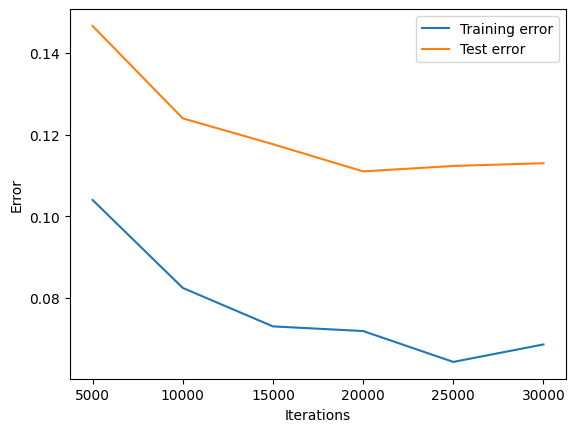

In [32]:
with open("../hyperparameters/gauss_svm2.json") as f:
    best_param = json.load(f)

model = predictors.KernelSVM(
    epochs_per_step=5000,
    regularization=best_param["regularization"],
    kernel=kernels.gaussian(best_param["gamma"]),
    rand=random.Random(1),
)

train_err, test_err, epochs = train_by_steps(model, 30000, 5000)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Iterations")
plt.ylabel("Error")

with open("../experiments/svm_gauss.json", "w") as f:
    json.dump({"train_err": train_err, "test_err": test_err, "epochs": epochs}, f)

plt.show()

# Benchmarks

In [33]:
from timeit import timeit


def benchmark(
    model: BinaryClassifier,
    epochs_step: int,
    max_epochs: int,
    test_size: int = 1000,
    trainX=trainX,
    trainY=trainY,
    testX=testX,
    log=True,
) -> tuple[list[float], list[float], list[int]]:
    epochs = range(epochs_step, max_epochs + 1, epochs_step)
    train_times = []
    predict_times = []
    warm = False
    for e in epochs:
        if log:
            print("Epoch:", e, end="\r")
        train_times.append(
            (train_times[-1]
            if len(train_times) > 0
            else 0) + timeit(lambda: model.fit(trainX, trainY, warm), number=1)
        )
        predict_times.append(timeit(lambda: model.predict(testX[:test_size]), number=1))
        warm = True
    if log:
        print()
    return train_times, predict_times, list(epochs)

## Perceptron

Epoch: 20
Epoch: 20
Epoch: 20


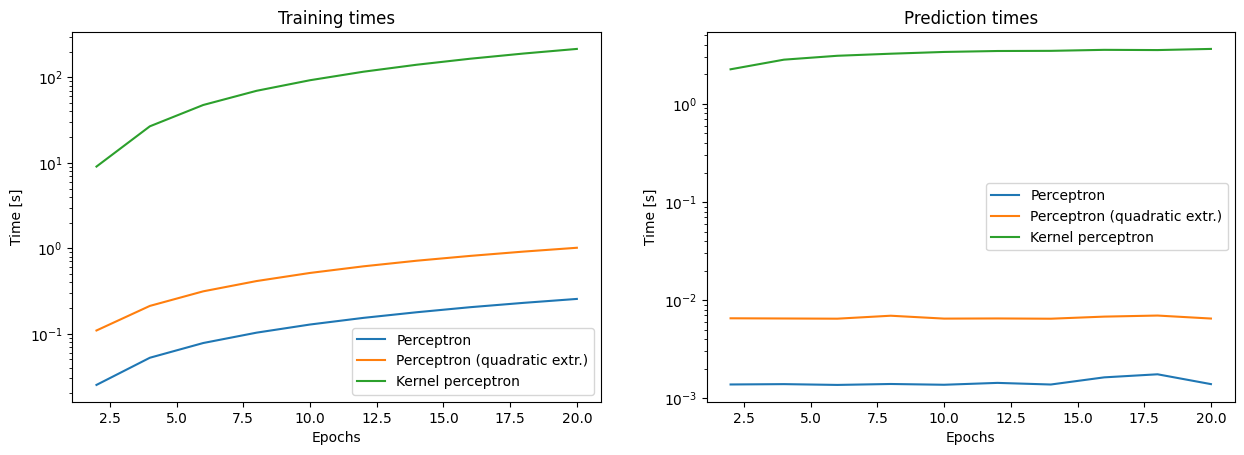

In [34]:
model = predictors.Perceptron(2)
quad_model = predictors.Perceptron(2)
kernel_model = predictors.KernelPerceptron(kernel=kernels.polynomial(4))

quad_trainX = [utils.quadratic_extraction(x) for x in trainX]
quad_testX = [utils.quadratic_extraction(x) for x in testX]

train_times, predict_times, epochs = benchmark(model, 2, 20)
qtrain_times, qpredict_times, qepochs = benchmark(model, 2, 20, trainX=quad_trainX, testX=quad_testX)
ktrain_times, kpredict_times, kepochs = benchmark(kernel_model, 2, 20)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)

axs[0].set_title("Training times")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Time [s]")
axs[0].set_yscale("log")
axs[0].plot(epochs, train_times)
axs[0].plot(epochs, qtrain_times)
axs[0].plot(epochs, ktrain_times)
axs[0].legend(["Perceptron", "Perceptron (quadratic extr.)", "Kernel perceptron"])

axs[1].set_title("Prediction times")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Time [s]")
axs[1].set_yscale("log")
axs[1].plot(epochs, predict_times)
axs[1].plot(epochs, qpredict_times)
axs[1].plot(epochs, kpredict_times)
axs[1].legend(["Perceptron", "Perceptron (quadratic extr.)", "Kernel perceptron"])
plt.show()

## SVM

Epoch: 2000
Epoch: 2000
Epoch: 2000


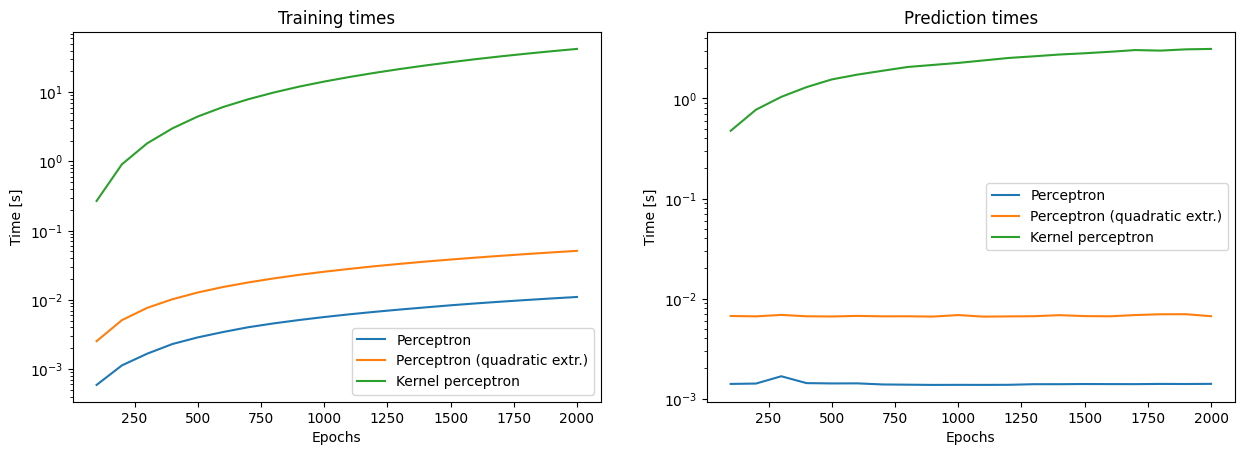

In [35]:
model = predictors.SVM(100)
quad_model = predictors.SVM(100)
kernel_model = predictors.KernelSVM(kernel=kernels.polynomial(4))

quad_trainX = [utils.quadratic_extraction(x) for x in trainX]
quad_testX = [utils.quadratic_extraction(x) for x in testX]

train_times, predict_times, epochs = benchmark(model, 100, 2000)
qtrain_times, qpredict_times, qepochs = benchmark(model, 100, 2000, trainX=quad_trainX, testX=quad_testX)
ktrain_times, kpredict_times, kepochs = benchmark(kernel_model, 100, 2000)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)

axs[0].set_title("Training times")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Time [s]")
axs[0].set_yscale("log")
axs[0].plot(epochs, train_times)
axs[0].plot(epochs, qtrain_times)
axs[0].plot(epochs, ktrain_times)
axs[0].legend(["Perceptron", "Perceptron (quadratic extr.)", "Kernel perceptron"])

axs[1].set_title("Prediction times")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Time [s]")
axs[1].set_yscale("log")
axs[1].plot(epochs, predict_times)
axs[1].plot(epochs, qpredict_times)
axs[1].plot(epochs, kpredict_times)
axs[1].legend(["Perceptron", "Perceptron (quadratic extr.)", "Kernel perceptron"])
plt.show()